# Building Data Genome Project 2.0
## Buildings normalized consumption

Biam! (pic.biam@gmail.com)

In [1]:
# data and numbers
import numpy as np
import pandas as pd
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
%matplotlib inline

import pandas as pd
from sklearn import preprocessing

In [2]:
path_raw = "..//data//meters//raw//"
path_meta = "..//data//metadata//"

# Introduction

In this notebook will be plot the normalized daily consumption. This is, daily energy consumption per area unit (square feet) of the building.<br>
Here is used the raw meter data, without processing outliers or missing values.

# Metadata

In [3]:
meta = pd.read_csv(
    path_meta + "metadata.csv",
    usecols=[
        "building_id",
        "site_id",
        "sqm"
    ]
)
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   building_id  1636 non-null   object 
 1   site_id      1636 non-null   object 
 2   sqm          1636 non-null   float64
dtypes: float64(1), object(2)
memory usage: 38.5+ KB


# Functions

In [4]:
# This function normalize all meters data automatically
def normalizeData(metername):
    # load data
    df = pd.read_csv(path_raw + metername + ".csv")
    
    # Transform timestamp to datetime object type
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")

    # Melt meter dataset
    df = pd.melt(
        df, id_vars="timestamp", var_name="building_id", value_name="meter_reading",
    )  
    
    # Calculate daily consumption
    df = df.groupby(["building_id",df.timestamp.dt.date]).sum().reset_index()
    
    # Add area column
    df = pd.merge(df, meta[["building_id", "sqm"]], how="left", on="building_id")

    # Normalize meter reading
    df["norm_reading"] = df["meter_reading"] / df["sqm"]
    df = df.drop(["meter_reading", "sqm"], axis=1)
        
    # Unmelt
    df = df.pivot(index="timestamp", columns="building_id", values="norm_reading")       
  
    # Scale (min-max)
    row_list = df.index # timestamp
    col_list = df.columns # building names  
    x = df.values #returns a numpy array
    
    scaler = preprocessing.MinMaxScaler()
    x_scaled = scaler.fit_transform(x) # standard scaling
    
    df = pd.DataFrame(x_scaled) # as data frame
    # rename columns
    col_rename_dict = {i:j for i,j in zip(df.columns, col_list)}
    df.rename(columns=col_rename_dict, inplace=True)
    # rename rows
    row_rename_dict = {i:j for i,j in zip(df.index, row_list)}
    df.rename(index=row_rename_dict, inplace=True)
    
    # Sort
    df = df.T.loc[df.T.sum(axis=1).sort_values().index]
    
    return df

# One figure to subplot them all

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


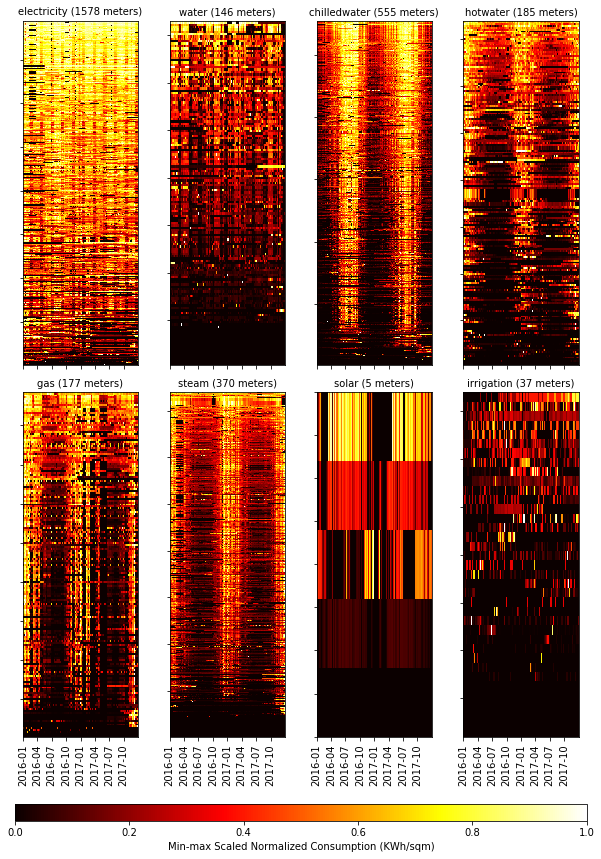

In [5]:
fig, axes = plt.subplots(2, 4, sharex = True, figsize=(8.27,11.69))
axes = axes.flatten()

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    
    df = normalizeData(j)
    
    # Get the data
    x = mdates.drange(df.columns[0], df.columns[-1] + dt.timedelta(days=1), dt.timedelta(days=1))
    y = np.linspace(1, len(df), len(df)+1)
    
    # Plot
    ax = axes[i]
    data = np.array(df)
    cmap = plt.get_cmap('hot')
    qmesh = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True, vmin=0, vmax=1)
    # Axis
    ax.axis('tight')  
    ax.xaxis_date() # Set up as dates
    ax.tick_params("x", labelrotation=90)
    ax.set_yticklabels([])
    ax.set_title(j + " (" + str(int(max(y))) + " meters)", fontdict={'fontsize':10})

# Color bar  
cbaxes = fig.add_axes([0.025, 0.02, 0.96, 0.02]) 
cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax = cbaxes)
cbar.set_label('Min-max Scaled Normalized Consumption (KWh/sqm)')

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

In [6]:
fig.savefig("..\\figures\\normalizedConsumption_all.jpg", dpi=300, bbox_inches='tight')

# Bibliography

- Miller, C., 2017. Screening Meter Data: Characterization of Temporal Energy Data from Large Groups of Non-Residential Buildings. ETH Zürich, Zurich, Switzerland.